In [91]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [92]:
# Read the data
X = pd.read_csv('../../data/home-data-for-ml-course/train.csv', index_col='Id') 
X_test = pd.read_csv('../../data/home-data-for-ml-course/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [93]:
# Apply one hot transformation to object columns
object_cols = [col for col in X.columns if X[col].dtype == 'object']
high_cardinality_cols = [col for col in object_cols if X[col].dtype == 'object' and X[col].nunique() >= 10]
low_cardinality_cols = [col for col in object_cols if X[col].dtype == 'object' and X[col].nunique() < 10]

# Fit, transform
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_X_train = pd.DataFrame(onehot.fit_transform(X_train[low_cardinality_cols])) # Your code here
OH_cols_X_valid = pd.DataFrame(onehot.transform(X_valid[low_cardinality_cols])) # Your code here

# Reapply index
OH_cols_X_train.index = X_train.index
OH_cols_X_valid.index = X_valid.index

# Drop object columns
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Combine everything
OH_X_train = pd.concat([num_X_train, OH_cols_X_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_X_valid], axis=1)


In [94]:
def get_mse(number_of_nodes):
    decision_tree_model = DecisionTreeRegressor(random_state=0, criterion='mse', max_leaf_nodes=number_of_nodes)
    decision_tree_model.fit(OH_X_train, y_train)
    preds = decision_tree_model.predict(OH_X_valid)
    my_mse = mean_squared_error(preds, y_valid)
    return my_mse

In [95]:
nodes = range(100, 1001, 100)
mse_values = {node: get_mse(node) for node in nodes}

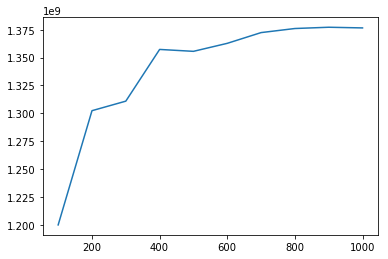

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mse_values.keys(), mse_values.values())
plt.show()